In [1]:
from sklearn.neural_network import MLPClassifier
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.multioutput import ClassifierChain
from sklearn.metrics import jaccard_score, multilabel_confusion_matrix, precision_recall_fscore_support, precision_score
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import preprocessing
from skopt import BayesSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.svm import SVC

In [2]:
x = np.load('../Part1.npy')
Y_t = np.load('../train.npy/y_train.npy')
#X_train = (x-np.min(x))/(np.max(x)-np.min(x))
xt = np.load('../Part2.npy')
Y_test = np.load('../test.npy/Y_Test.npy')
#X_test = (xt-np.min(xt))/(np.max(xt)-np.min(xt))
x_add = np.load('../Part3.npy')
y_add = np.load('../additional.npy/Y_additional.npy')
#x_add = (x_add-np.min(x_add))/(np.max(x_add)-np.min(x_add))
Y_train = np.concatenate((Y_t, Y_test, y_add))
X_train = np.concatenate((x, xt, x_add))
#X_train = (X_train-np.min(X_train))/(np.max(X_train)-np.min(X_train))
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

In [3]:
X_test = np.load('X_single.npy')
Y_test = np.load('Y_single.npy')
scaler = preprocessing.StandardScaler().fit(X_test)
X_test = scaler.transform(X_test)

In [4]:
class OvR_SVM(BaseEstimator, ClassifierMixin):
    def __init__(self, tol, reg, kernel, coef0, degree):
        super(OvR_SVM, self).__init__()
        self.tol = tol
        self.reg = reg
        self.coef0 = coef0
        self.kernel = kernel
        self.degree = degree
        self.model = SVC(tol=self.tol, C = self.reg, class_weight='balanced', kernel = self.kernel, coef0=self.coef0, degree = self.degree)
        self.ovr = OneVsRestClassifier(self.model)

    def fit(self, X_train, Y_train):
        #self.chain = ClassifierChain(self.model, order="random", random_state=1)
        return self.ovr.fit(X_train, Y_train)
    
    def score(self, X_test, Y_test):
        Y_pred_chain = self.ovr.predict(X_test)
        precision = precision_score(Y_test, Y_pred_chain>=0.5, average='samples')
        return precision 

In [5]:
search_space = {
    'tol': (0.0001,0.1),
    'reg': (0.1, 1),
    'kernel': ['poly', 'rbf', 'linear', 'sigmoid','precomputed'],
    'coef0':(0.0,1),
    'degree':(2,8)
}

test = OvR_SVM(0.0001, 1, 'rbf', coef0=0.0, degree = 3)
opt = BayesSearchCV(test, search_space, n_iter=50, cv=7, n_jobs=-1)
opt.fit(X_train, Y_train)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

BayesSearchCV(cv=7,
              estimator=OvR_SVM(coef0=0.0, degree=3, kernel='rbf', reg=1,
                                tol=0.0001),
              n_jobs=-1,
              search_spaces={'coef0': (0.0, 1), 'degree': (2, 8),
                             'kernel': ['poly', 'rbf', 'linear', 'sigmoid',
                                        'precomputed'],
                             'reg': (0.1, 1), 'tol': (0.0001, 0.1)})

In [6]:
print("Best parameters found: ", opt.best_params_)
print("Best score: ", opt.best_score_)

Best parameters found:  OrderedDict([('coef0', 0.8697018225641814), ('degree', 7), ('kernel', 'rbf'), ('reg', 0.98279200778346), ('tol', 0.060876801421565006)])
Best score:  0.24580500077308234


In [7]:
svm = SVC(C=0.18, tol=0.046, kernel='rbf', coef0=0.79, degree=6)
ovr = OneVsRestClassifier(svm)
ovr.fit(X_train, Y_train)

OneVsRestClassifier(estimator=SVC(C=0.18, coef0=0.79, degree=6, tol=0.046))

In [8]:
pred = ovr.predict(X_test)

In [9]:
m = multilabel_confusion_matrix(Y_test, pred)
print(m)

[[[6317    0]
  [ 388    0]]

 [[6200    0]
  [ 505    0]]

 [[6254    0]
  [ 451    0]]

 [[6068    0]
  [ 637    0]]

 [[5945    0]
  [ 760    0]]

 [[6023    0]
  [ 682    0]]

 [[5867  117]
  [ 689   32]]

 [[6079    0]
  [ 626    0]]

 [[6128    0]
  [ 577    0]]

 [[6125    0]
  [ 580    0]]

 [[5927    0]
  [ 776    2]]]


In [10]:
precision = np.array([x[1,1]/(x[1,1]+x[0,1]) for x in m])
recall = np.array([x[1,1]/(x[1,1]+x[1,0]) for x in m])
f1 = 2*precision*recall/(precision+recall)
print(precision, recall, f1)

[      nan       nan       nan       nan       nan       nan 0.2147651
       nan       nan       nan 1.       ] [0.         0.         0.         0.         0.         0.
 0.0443828  0.         0.         0.         0.00257069] [       nan        nan        nan        nan        nan        nan
 0.07356322        nan        nan        nan 0.00512821]


/var/folders/y1/pjhgyq7s17zfyt6wmlhs0jq40000gn/T/ipykernel_74080/2716747972.py:1: RuntimeWarning: invalid value encountered in long_scalars
  precision = np.array([x[1,1]/(x[1,1]+x[0,1]) for x in m])


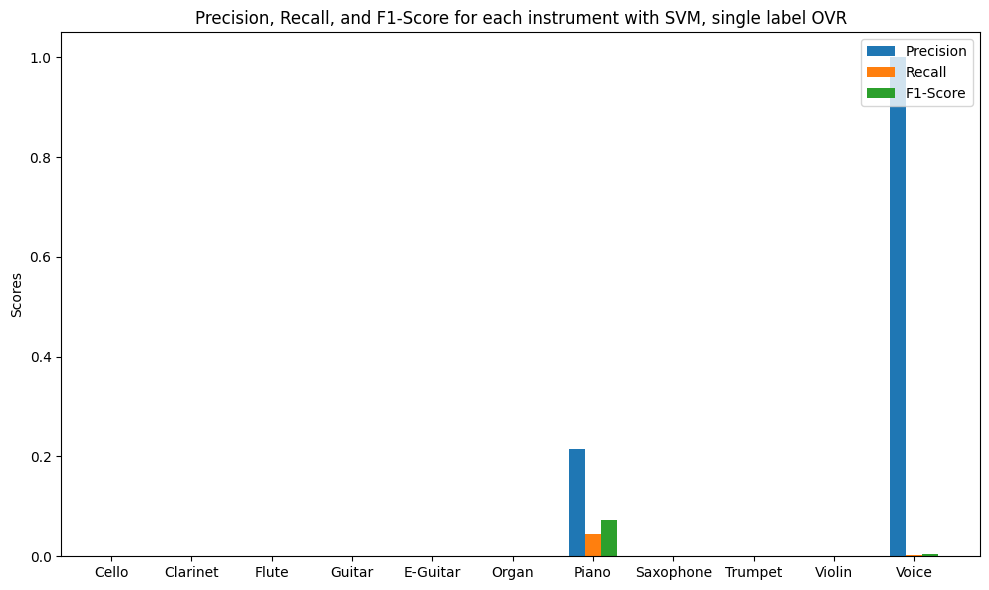

In [11]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(10, 6))
x_ax = ["Cello","Clarinet", "Flute", "Guitar", "E-Guitar", "Organ", "Piano", "Saxophone", "Trumpet", "Violin", "Voice"]
x = np.arange(len(precision))  # the label locations
width = 0.2  # the width of the bars
rects1 = ax.bar(x - width, precision, width, label='Precision')
rects2 = ax.bar(x, recall, width, label='Recall')
rects3 = ax.bar(x + width, f1, width, label='F1-Score')
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, and F1-Score for each instrument with SVM, single label OVR')
ax.set_xticks(x)
ax.set_xticklabels([i for i in x_ax])
ax.legend()
fig.tight_layout()
plt.savefig('ScoresSVMsingleOVR.png')
plt.show()